In [1]:
from sympy.physics.vector import Point,ReferenceFrame as rf
from sympy.physics.mechanics import  inertia, RigidBody, Lagrangian, LagrangesMethod, Particle, angular_momentum
from sympy.physics.mechanics import KanesMethod, Dyadic
from sympy.physics.vector import dynamicsymbols
from sympy import Matrix, symbols, simplify,diff, solve
from sympy.physics.vector import init_vprinting
init_vprinting(pretty_print=True)
import sympy as sp
from sympy import lambdify
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib.patches import Rectangle
from matplotlib import animation
import os
import time
import control as ct
from control import lqr
import numpy as np
from numpy import linalg as la
from numpy import rad2deg, deg2rad
from numpy.linalg import inv,pinv
import scipy
from scipy.integrate import odeint
from scipy.optimize import minimize
import math as m
from scipy.interpolate import CubicSpline
from scipy.interpolate import BSpline
from itertools import islice
from numpy.linalg import inv 
Mc,lc,Ix,Iy,Iz,Ixz,K,J = symbols('M_c,l_c,I_x,I_y,I_z,I_xz,K,J')
q1,q4, ql,qb,phi = dynamicsymbols(' q1 q4 ql q_b phi')
qa1, qa2 = dynamicsymbols('qa1,qa2')
qr, ql,x,y,z = dynamicsymbols('q_r,q_l,x,y,z')
bt = symbols('beta')
l12, l13 , l34, l25, l24,l01= symbols("l12 l13 l34 l25 l24 l01")
r ,g, d,kt,t = symbols("r g d kt t")
la1, la2,lm1,lm2,lm3,lm4 = symbols('la1 la2 lm1 lm2 lm3,lm4')
mb, m1,m2,m3,m4,mw, ma1, ma2, mext = symbols('mb m1 m2 m3 m4 mw ma1 ma2 mext')
Tl,Tr = symbols('Tl Tr')
phi, th = dynamicsymbols('phi,theta')
Tw,Tm,Ta1,Ta2 = symbols('Tw,Tm,Ta1,Ta2')
xc,yc,phi,x = dynamicsymbols('xc yc phi x')
values = {
            mw:0.268, m1: 0.127, m2 : 0.105, m3:0.103, mb: 1.512, ma1:0.092526,ma2:0.109,
            l01: 0.190, l12: 0.050, l24:0.193, l13: 0.188, l34:0.093, la1:0.20, la2:0.20,
            r:0.070, g:9.81, d:0.210, bt: np.deg2rad(46.1),
            Mc: 2.919
}
# vvalues = {kt :1}

from eom import eom as eqOfMotion
eom = eqOfMotion(kt = 0.85)

In [2]:
def vectomat(vector,N,s=0):
    if s==0:
        return simplify( Matrix([vector.dot(N.x), vector.dot(N.y), vector.dot(N.z)]))
    else:
        return  Matrix([vector.dot(N.x), vector.dot(N.y), vector.dot(N.z)])
def rtang(alpha):
    if alpha>0:
        alpha = alpha
    else:
        alpha = alpha+np.pi
    return alpha   

def fourbar(t3):
    tm = t3-np.pi+values[bt]
    l = values[l13]; h =values[l34]
    g = values[l24]; f = values[l12]
    ln = np.sqrt(l**2+h**2-2*l*h*m.cos(tm))
    alpha = m.acos((g**2+f**2-ln**2)/(2*g*f))
    alpha = rtang(alpha)
    gamma = m.acos( ( h**2+  ln**2-  l**2)/(2*h*ln) )+\
            m.acos( ( g**2 + ln**2 - f**2)/(2*g*ln) )
    
    gamma = rtang(gamma)
    lembda = 2*np.pi- (gamma + alpha + tm)
    #                   q2        q3      q4
    return np.array([np.pi-alpha, lembda, t3])
def spround(exp,n=3):
    exp =exp.expand()
    for a in sp.preorder_traversal(exp):
        if isinstance(a, sp.Float):
            exp = exp.subs(a, round(a, n))
    return exp
def figsize(i,j):
    rcParams['figure.figsize']= (j,i)

In [3]:
q3 = sp.Function('q3')(q4)
q2 = sp.Function('q2')(q4)
q2

In [4]:
q=Matrix([xc,yc,phi,ql,qr,q1,q4,qa1,qa2])
qdot = q.diff()
lq = len(q)

In [5]:
N = rf('N')
C = N.orientnew('C','Axis',[phi,N.z])
Lw = C.orientnew('Lw','Axis',[ql,-C.y])
Rw = C.orientnew('Rw','Axis',[qr,-C.y])
L1 = C.orientnew('L1','Axis',[q1,-C.y])
L2 = L1.orientnew('L2','Axis',[q2,-L1.y])
L3 = L1.orientnew('L3','Axis',[q3,-L1.y])
B = L3.orientnew('B','Axis', [q4,-L3.y])
L4 = B.orientnew('L4','Axis',[bt,-B.y])
A1 = B.orientnew('A1','Axis',[qa1,-B.y])
A2 = A1.orientnew('A2','Axis',[qa2,-A1.y])

In [6]:
G = Point('G')
G.set_vel(N,0)
Cb = G.locatenew('Cb',xc*N.x+yc*N.y+r*N.z)
p0 = Cb.locatenew('p0',  d/2*C.y)
pc1 = p0.locatenew('pc1',-r*N.z)
p1 = p0.locatenew('p1',l01*L1.x)
p2 = p1.locatenew('p2',l12*L1.x)
p3 = p1.locatenew('p3',l13*L3.x)
p34 = p3.locatenew('p34',l34*L4.x)
p24 = p2.locatenew('p24',l24*L2.x)

p01 = Cb.locatenew('p01',-d/2*C.y)
pc2 = p01.locatenew('pc2',-r*N.z)
p11 = p01.locatenew('p11',l01*L1.x)
p21 = p11.locatenew('p21',l12*L1.x)
p31 = p11.locatenew('p31',l13*L3.x)
p341 = p31.locatenew('p341',l34*L4.x)
p241 = p21.locatenew('p241',l24*L2.x)

pb = p3.locatenew('pb',-6.501/1000*B.x+147/1000*B.z-d/2*B.y)
pa1 =pb.locatenew('pa1',la1*A1.x)
pa2 =pa1.locatenew('pa2',la2*A2.x)

rec_cen = pb.locatenew('rec',-0.186/2*B.x\
                       -0.186*B.z
                       )

In [7]:
c1 = p0.locatenew('c1',0.130055*L1.x)
c2 = p2.locatenew('c2',0.102766*L2.x)
c3 = p1.locatenew('c3',0.097766*L3.x)

c11 = p01.locatenew('c1',0.130055*L1.x)
c21 = p21.locatenew('c2',0.102766*L2.x)
c31 = p11.locatenew('c3',0.097766*L3.x)

cb = pb.locatenew('cb',-0.017192*B.x-0.085*B.z)
ca1 = pb.locatenew("ca1",0.080669*A1.x)
ca2 = pa1.locatenew("ca2",0.103429*A2.x)

In [8]:
## coordinates 
qinput = Matrix([xc,yc,phi,q1,q2,q3,q4,qa1,qa2])

points = [p0,p1,p2,p24,p3,p34,pb,pa1,pa2,rec_cen]
robocord = []
for pnt in points:
    robocord.append(vectomat(pnt.pos_from(G),N,1).T)

robocord= Matrix(robocord).T
robocord.row_del(1)
robopoints = lambdify(qinput,robocord.subs(values),modules='numpy')

cpoints = [c1,c2,c3,cb,ca1,ca2]
robocom = []
for pnt in cpoints:
    robocom.append(vectomat(pnt.pos_from(G),N,1).T)
robocom= Matrix(robocom).T
robocom.row_del(1)
robocpoints = lambdify(qinput,robocom.subs(values),modules='numpy')

In [9]:
def com():
    cn = [c1,c2,c3,cb,ca1,ca2,c11,c21,c31]
    mn = [m1,m2,m3,mb,ma1,ma2,m1,m2,m3]
    cm = Matrix([[0,0,0]]).T
    for i in range(len(cn)):
        cm += vectomat(cn[i].pos_from(G),N,1)*mn[i]
    return (cm/sum(mn)).subs(values)
com_N = lambdify(qinput,com(),modules='numpy')

In [10]:
def plotline(q):
    fig, ax = plt.subplots()
    points = robopoints(*q)
    com = com_N(*q)
    pnts1 = points[:,:4]
    pnts2 = np.hstack((points[:,1:2],points[:,4:5]))
    pnts3 = points[:,6:-1]
    ax.plot(pnts1[0,:], pnts1[1,:], color='#28b34b', linewidth=4, zorder=2)
    ax.plot(pnts2[0,:], pnts2[1,:], color='#28b34b', linewidth=4, zorder=2)
    ax.plot(pnts3[0,:], pnts3[1,:], color='#28b34b', linewidth=4, zorder=2)
    circle = plt.Circle((pnts1[0,0], pnts1[1,0]), 0.07, facecolor='#4a54a4', edgecolor='k')
    squre = Rectangle((points[0,9], points[1,9]), 0.186, 0.186, angle=rad2deg(q[3]+q[5]+q[6]), 
                      facecolor='#4a54a4', edgecolor='k')
    ax.add_patch(squre)
    ax.add_artist(circle)
    ax.scatter(pnts1[0,:], pnts1[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    ax.scatter(pnts2[0,:], pnts2[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    ax.scatter(pnts3[0,:], pnts3[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    cm = np.round([com[0,0]-q[0], com[2,0]], 3)
    ax.plot([-0.3, 0.8], [0, 0], 'k')
    ax.text(com[0,0]+0.15, com[2,0], f'COM: {cm[0],cm[1]}')
    # ax.set_xlim([-0.3, 0.8])
    ax.set_ylim([-0.05, 0.9])
    # axis('equal')
    ax.set_aspect('equal')
    return fig, ax
def ccc(q ):
    # rcParams['figure.figsize'] = (6,4)
    q = q.reshape(-1,)
    q = np.insert(q,1,0)
    q = np.insert(q,4,fourbar(q[4])[:2])[:9]
    # print(q)
    cm = com_N(*q)
    print(cm.reshape(-1,))
    plotline(q)
    plot(cm[0],cm[2],'ro')

In [11]:
qind = Matrix([x,phi,q1,q4,qa1,qa2])
qdep = Matrix([q2,q3,diff(q2,q4), diff(q3,q4),diff(q2,q4,2), diff(q3,q4,2)])
qn = Matrix.vstack(qind,qind.diff(),qdep )
us = Matrix([Tl,Tr,-Tl-Tr,2*Tm,Ta1,Ta2])
usfun = sp.lambdify([Tl,Tr,Tm,Ta1,Ta2],us,modules = 'numpy')

### <center>    Cubic In Holonomic Constraints  </center>

In [12]:
fangs = []
for i in np.linspace(3.2,4.2,1000):
    fangs.append(fourbar(i))
fangs = np.array(fangs)
f2 = CubicSpline(fangs[:,2],fangs[:,0])
f3 = CubicSpline(fangs[:,2],fangs[:,1])

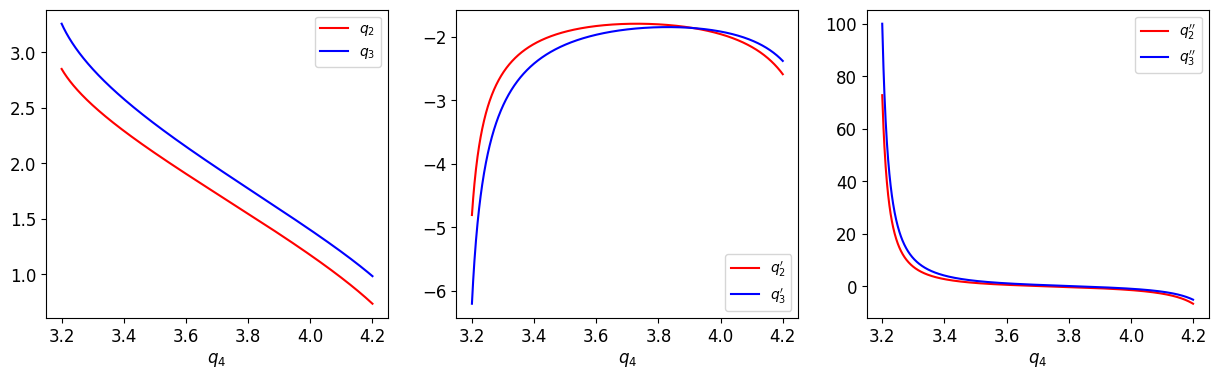

In [13]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Subplot 1
axs[0].plot(fangs[:, 2], f2(fangs[:, 2]), 'r')
axs[0].plot(fangs[:, 2], f3(fangs[:, 2]), 'b')
axs[0].legend([r'$q_2$', r'$q_3$'])
axs[0].set_xlabel(r'$q_4$', fontsize=12)
axs[0].tick_params(axis='both', labelsize=12)

# Subplot 2
axs[1].plot(fangs[:, 2], f2(fangs[:, 2], 1), 'r')
axs[1].plot(fangs[:, 2], f3(fangs[:, 2], 1), 'b')
axs[1].set_xlabel(r'$q_4$', fontsize=12)
axs[1].legend([r"$q_2'$", r"$q_3'$"])
axs[1].tick_params(axis='both', labelsize=12)

# Subplot 3
axs[2].plot(fangs[:, 2], f2(fangs[:, 2], 2), 'r')
axs[2].plot(fangs[:, 2], f3(fangs[:, 2], 2), 'b')
axs[2].legend([r"$q_2''$", r"$q_3''$"])
axs[2].set_xlabel(r'$q_4$', fontsize=12)
axs[2].tick_params(axis='both', labelsize=12)

plt.show()


### <center> Operating Points</center>


In [14]:
def Qconv(q): # 3 9
    q = np.array(q)
    #   x  phi q1 q4 qa1 qa2
    qder  = np.array([ f2(q[3]), f3(q[3]), f2(q[3],1), f3(q[3],1), f2(q[3],2), f3(q[3],2)])
    return np.append(q,qder)
 
def operatingPoint(q0,q1):
    def Constfun(qu):
        q = np.append(qu[:5] , np.zeros((6,)))
        q = np.insert(q, 2, [q1])
        u = qu[5:]
        x = Qconv(q)
        # x2 = np.dot(inv(eom.mqn(*x)) , eom.gn(*x) + usfun(*u))
        x2 = -eom.gn(*x) + usfun(*u)
        return x2.reshape(-1,)

    def objfun(qu):
        u = qu[5:]
        return np.linalg.norm(u)
    bounds = [(None,None),(None,None),
            #   (0.534,1.0276) ,
               (3.55840321, 3.99440321),
            #   (None,None),(None,None)
              (np.pi/3,np.pi-np.pi/3),(None,None)
              ] + [(None,None)]*(5)
    const = {'type':'eq','fun': Constfun}
    sol = minimize(objfun, q0, bounds = bounds,constraints = const )
    opoints = np.insert(sol['x'],2,[q1])
    print('const',Constfun(sol['x']))
    return opoints,sol
                          # x phi q4        qa1        qa2           Tw Tr Tm Ta1 Ta2
q0 = np.append( np.array([0, 0,   3.900e+00, 2.338e+00,  5.387e-01]), np.zeros((5,)) )
# q0 = np.append( np.array([0, 0,   3.960e+00, 1.50,  0.05]), np.zeros((5,)) )

In [18]:
rcParams['figure.figsize'] = (6,4)
qpoint,_ = operatingPoint( q0,q1 = deg2rad(41.42) )
print('Energy',_['fun'])
ccc(qpoint)
qpoint

const [ 0.00000000e+00  0.00000000e+00 -1.97913907e-11  4.32048585e-11
 -4.63750674e-13 -5.82913653e-13]
Energy 0.0005699839359006478
[8.43547454e-13 0.00000000e+00 3.51504913e-01]


array([-2.50128821e-15,  0.00000000e+00,  7.22915376e-01,  3.78003351e+00,
        1.54146912e+00, -4.04384971e-04,  0.00000000e+00,  0.00000000e+00,
       -5.58120184e-04, -1.15687230e-04,  1.12203887e-07])

### <center> Linearization</center>


In [19]:
def fun(x,u):
    q  = Qconv(x)
    u = usfun(*u)
    x2 = x[6:]
    f1 = x2
    f2 = np.dot( inv(eom.mqn(*q)), (-eom.cqn(*q) + u ) )
    return np.append(f1,f2)

def Linearize(fun,x0,u0,eps=1e-08):
    A = np.zeros((len(x0),len(x0)))
    B = np.zeros((len(x0),len(u0)))
    
    for i in range(len(x0)):
        xn = x0.copy()
        xn[i] += eps
        A[:,i] = (fun(xn,u0)-fun(x0,u0))/eps
    
    for i in range(len(u0)):
        un = u0.copy()
        un[i] += eps
        B[:,i] = (fun(x0,un)-fun(x0,u0))/eps

    return A,B
x0 = np.append(qpoint[:6],np.zeros((6,)))
u0 = qpoint[6:]
A,B = Linearize(fun,x0,u0)
np.linalg.matrix_rank(ct.ctrb(A,B))

8

### <center> Holding Torque Analysis</center>


In [17]:
eng=[]
TMM = []
t1ang =  np.linspace(deg2rad(30),deg2rad(50),15)
for i in t1ang:
    qpoint,_ = operatingPoint( q0,q1 = i )
    _ = qpoint[-5:]
    eng.append(np.sum(_))
    TMM.append(_[2])
eng = np.array(eng)
TMM = np.array(TMM)

const [ 0.00000000e+00  0.00000000e+00 -3.45973440e-08  1.06042957e-07
 -7.94055222e-09  1.88124225e-10]
const [ 0.00000000e+00  0.00000000e+00 -2.13129816e-07  5.09044285e-07
 -8.99937970e-08  2.40247961e-09]
const [ 0.00000000e+00  0.00000000e+00 -3.14840255e-07  4.28276864e-07
 -2.41678337e-07  3.18819786e-09]
const [ 0.00000000e+00  0.00000000e+00 -5.80952642e-09  1.10892472e-08
 -2.80702193e-09  3.19639596e-11]
const [ 0.00000000e+00  0.00000000e+00 -1.31783795e-09  1.29891056e-09
 -1.25222299e-09  5.50735212e-12]
const [ 0.00000000e+00  0.00000000e+00 -3.15871571e-08  4.40400035e-08
 -2.16717480e-08  2.16757958e-10]
const [ 0.00000000e+00  0.00000000e+00 -1.14850462e-10  2.47791732e-10
 -1.59328471e-11  5.64939024e-13]
const [ 0.00000000e+00  0.00000000e+00 -2.90427569e-08  4.64343146e-08
 -1.22347998e-08 -7.48545251e-09]
const [ 0.00000000e+00  0.00000000e+00 -2.51221266e-12  1.18088562e-11
 -1.27362765e-12 -8.22543725e-13]
const [ 0.00000000e+00  0.00000000e+00  1.18870835e-09 

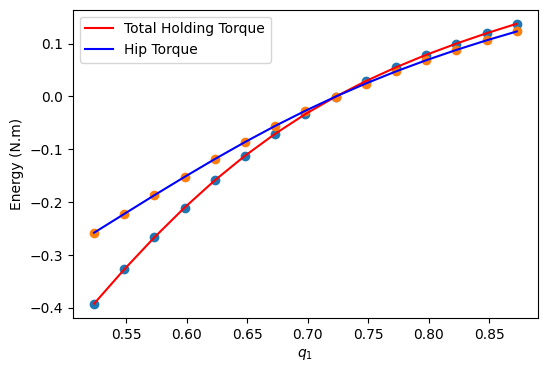

In [18]:
plot(t1ang,eng,'r')
plot(t1ang,TMM,'b')
scatter(t1ang,eng)
scatter(t1ang,TMM)
xlabel(r'$q_1$')
ylabel('Energy (N.m)')
legend(['Total Holding Torque','Hip Torque'])
show()

# Inverse Kinematic

In [22]:
def AnimePlotline(q,fig,ax):
    points = robopoints(*q)
    com = com_N(*q)
    limit = np.array([points[0,2],points[0,6]-0.100,
                      points[0,8],points[0,6]+0.100])
    pnts1 = points[:,:4]
    pnts2 = np.hstack((points[:,1:2],points[:,4:5]))
    pnts3 = points[:,6:-1]
    ax.plot(pnts1[0,:], pnts1[1,:], color='#28b34b', linewidth=4, zorder=2)
    ax.plot(pnts2[0,:], pnts2[1,:], color='#28b34b', linewidth=4, zorder=2)
    ax.plot(pnts3[0,:], pnts3[1,:], color='#28b34b', linewidth=4, zorder=2)
    circle = plt.Circle((pnts1[0,0], pnts1[1,0]), 0.07, facecolor='#4a54a4', edgecolor='k')
    squre = Rectangle((points[0,9], points[1,9]), 0.186, 0.186, angle=rad2deg(q[3]+q[5]+q[6]), 
                      facecolor='#4a54a4', edgecolor='k')
    ax.add_patch(squre)
    ax.add_artist(circle)
    ax.scatter(pnts1[0,:], pnts1[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    ax.scatter(pnts2[0,:], pnts2[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    ax.scatter(pnts3[0,:], pnts3[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    cm = np.round([com[0,0]-q[0], com[2,0]], 3)
    ax.plot(com[0],com[2],'ro')
    # ax.text(com[0,0]+0.15, com[2,0], f'COM: {cm[0],cm[1]}')
    ax.plot([-0.5, 2.0], [0, 0], 'k')
    # ax.set_xlim([-0.2,2.5])
    # ax.set_xlim([min(limit)-0.1, max(limit)+0.1])
    ax.set_ylim([-0.2,0.9])
    # ax.plot(x_,z_)
    ax.set_aspect('equal')
    # xlim([-0.2,0.6])
    # ylim([-0.1,0.9])
    return fig, ax
def Animeccc(q,fig,ax):
    q = q.reshape(-1,)
    q = np.insert(q,1,0)
    q = np.insert(q,4,fourbar(q[4])[:2])[:9]
    return AnimePlotline(q,fig,ax)

In [23]:
def atan2(dy,dx):
    if dy ==0 and dx == 0:
        return 0
    ang = np.arctan(abs(dy/dx))
    if dy>=0 and dx>=0:
        return ang 
    elif dy>=0 and dx<=0:
        return -ang
    elif dy<=0 and dx<=0:
        return ang
    elif dy<=0 and dx>=0:
        return -ang 

In [24]:
hols = vectomat(p24.pos_from(p34), L1).subs(values)
hols = hols.row_del(1)
pec = vectomat(pa2.pos_from(G).subs(values),N,1)
pec = Matrix.vstack(pec,hols)
pec = Matrix.vstack(pec,Matrix([q1 + q3 + q4 - 2 * sp.pi]))
Xefun = lambdify([xc,yc,phi,q1,q2,q3,q4,qa1,qa2],pec,modules = 'numpy')

In [25]:
class InvKin():
    def __init__(self,xeff,qc):
        self.xeff = xeff
        self.qc  =qc
        self.Q = np.diag([30,1,10,1,1,10,0.1,1])
        self.bnds = [
                     (None, None ), (None,None),
                     (0.534,1.0276),
                     (None, None ), (None,None),
                     (3.55840321, 3.99440321),
                     (np.pi/6,    np.pi-np.pi/6),
                     (None,None)
                    #  (-np.pi,np.pi)
                    ]
        self.const = [{'type':'eq','fun':self.ConstFun},
                      {'type':'ineq','fun':self.EnConstFun},
                    ]
        # self.q1 = q1
        self.phi = atan2(xeff[1]-qc[1] , xeff[0]-qc[0])
        self.temp = np.array([])

    #  x y phi q1  q4 qa1 qa2
    def Qconv(self,q):
        q = np.insert(q,2,self.phi)
        return q
    #  x y phi q1 q2 q3 q4 qa1 qa2

    def ConstFun(self,q):
        self.temp = np.append(self.temp,q[0])
        q = self.Qconv(q)
        fn = (Xefun(*q)).reshape(-1,) - np.append(self.xeff,[0,0,0])
        return fn
    
    def EnConstFun(self,q):
        w = abs(np.sin(q[-1]))
        ineq = np.array([w-0.701,1-w])
        return ineq        

    def Qconv2(self,q):
        q = np.insert(q,2,self.phi)
        q = np.delete(q,4)
        q = np.delete(q,4)
        q = np.delete(q,1)
        return q

    def ObjFun(self,q):
        obj = np.dot((q-self.qc), np.dot(self.Q , (q-self.qc)))
        return obj
    #  x y phi q1 q4 qa1 qa2
    def solveIK(self,):
        sol = minimize(self.ObjFun,self.qc,method='SLSQP',bounds = self.bnds,  constraints=self.const)
        print(self.ConstFun(sol['x']))
        return self.Qconv2(sol['x']), sol['x']


[-5.48492432e-10  0.00000000e+00 -5.99726158e-10  0.00000000e+00
 -1.30104261e-16  0.00000000e+00]
[-0.25011799  0.          0.39150109]


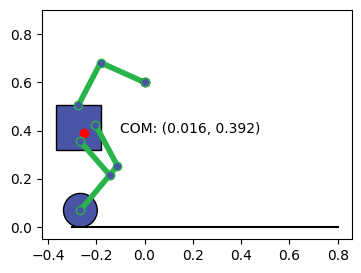

In [26]:
%matplotlib inline
figsize(6,4)
qc = np.array([0,  0,  7.85398163e-01,0,0 , 3.87503035e+00,
                1.86246296e+00, -3.03414032e-01])
xeff = np.array([0  , 0.  , 0.6])
Ik1 = InvKin(xeff,qc)
sl,qnc = Ik1.solveIK()
# sl = np.delete(sl,1)
# sl = np.insert(sl,2,np.pi/4)
# print(sl,qnc)
ccc(sl)
plot(xeff[0],xeff[2],'ko')
show()

## <center> End Effecter Inverse Kinematics </center>


### <center> Linear Trajectory IK</center>


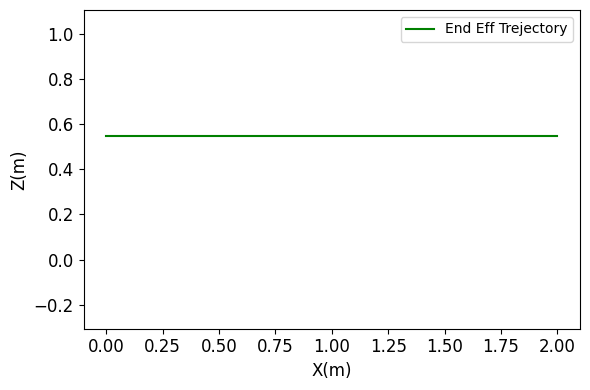

In [27]:
# %matplotlib inline
# %matplotlib qt
x_ = np.linspace(0,2,20)
y_ = np.zeros_like(x_)
z_ = 0.55*np.ones_like(x_)
state = np.vstack((x_,y_,z_))
figsize(4,6)
plot(x_,z_,'g')
axis('equal')
ylim([0,.8])
xlabel('X(m)',fontsize = 12); ylabel('Z(m)',fontsize = 12)
tick_params(axis='both',labelsize = 12)
legend(['End Eff Trejectory'])
tight_layout()
show()

In [28]:
def pathGen(state,qc):
    path = []
    for i in range(state.shape[1]):
        xeff = state[:,i]
        
        Ik = InvKin(xeff,qc)
        ang,qc = Ik.solveIK()
        path.append(ang)
    path = np.array(path)
    return path
qc = np.array([ -0.2  ,  0.        ,  0.78539816,  0.        ,  0.        ,
        3.87503035,  1.86246296, -0.30341403])
path = pathGen(state,qc)

[-1.99423811e-14  0.00000000e+00 -1.31006317e-14 -8.63198402e-15
 -3.21418239e-14 -8.88178420e-16]
[-5.23344562e-11  0.00000000e+00 -9.45430401e-11 -5.42568074e-11
 -1.04230383e-10  0.00000000e+00]
[-5.09075559e-10  0.00000000e+00 -8.25854940e-11 -2.48870230e-11
 -3.03318059e-10  0.00000000e+00]
[-4.30763702e-10  0.00000000e+00 -1.34957934e-10 -6.47179532e-11
  1.44450838e-10  8.88178420e-16]
[-9.90874049e-14  0.00000000e+00 -1.18571819e-13 -6.63913369e-14
 -1.07509487e-13  0.00000000e+00]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.60208521e-18 0.00000000e+00]
[-2.22044605e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.03576608e-17 -8.88178420e-16]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.77555756e-17
 -2.42861287e-17  8.88178420e-16]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.03576608e-17 0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.35308431e-16  0.00000000e+00]
[0.00000000e+00 0.0000

In [30]:
import matplotlib.pyplot as plt
%matplotlib qt
close()
laby = ['$x(m)$', '$\phi(rad)$', '$q_1(rad)$', '$q_4(rad)$', '$q_{a_{1}}(rad)$', '$q_{a_{2}}(rad)$']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  
# plt.figure(figsize=(4, 8))
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(path[:, i],colors[i],linewidth =2)
    plt.legend([laby[i]], fontsize=10,loc='upper right')
    tick_params(axis='both', labelsize=12,)
annotate('Inverse kinematic of Sinusoidal Trajectory', xy=(0.5, 8.7), xycoords='axes fraction',
            fontsize=20, ha='center', va='bottom')  # Add the new title annotation
plt.xlabel('t (sec)', fontsize=12)
text(-2.1, 1.8, 'State', ha='center', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(hspace=0.5, wspace=0.25)

In [249]:
close()
%matplotlib qt
figsize(12,18)
fig, ax = subplots()
# for i in [0,5,10,15,19]:
for i in range(20):
    fig ,ax = Animeccc(path[i],fig,ax)
ax.plot(x_,z_,'r',linewidth = 3)
ax.tick_params(axis='both', labelsize=16,)
ax.set_title('Inverse Kinematic of Sinusoidal Trajectory',fontsize = 18)
ax.set_xlabel('X(m)',fontsize = 16)
ax.set_ylabel('Z(m)',fontsize = 16)
show()
# savefig("C:\\Users\\pkver\\Desktop\\Thesis\\Tracking\\invkin sin.png")

### <center> sine wave IK</center>


In [46]:
# %matplotlib inline
%matplotlib qt
t_ = np.linspace(0,5,20)
x_ = np.linspace(0,2,20)
y_ = np.zeros_like(x_)
z_ = 0.55+0.15*np.sin(x_*5) 
state = np.vstack((x_,y_,z_))
figsize(4,6)
plot(x_,z_,'g')
axis('equal')
ylim([0,.8])
xlabel('X(m)',fontsize = 12); ylabel('Z(m)',fontsize = 12)
tick_params(axis='both',labelsize = 12)
legend(['End Eff Trejectory'])
tight_layout()
show()

In [47]:
def pathGen(state,qc):
    path = []
    for i in range(state.shape[1]):
        xeff = state[:,i]
        
        Ik = InvKin(xeff,qc)
        ang,qc = Ik.solveIK()
        path.append(ang)
    path = np.array(path)
    return path
qc = np.array([ -0.2  ,  0.        ,  0.78539816,  0.        ,  0.        ,
        3.87503035,  1.86246296, -0.30341403])
path = pathGen(state,qc)

[-1.99423811e-14  0.00000000e+00 -1.31006317e-14 -8.63198402e-15
 -3.21418239e-14 -8.88178420e-16]
[-3.99319466e-13  0.00000000e+00 -1.40887302e-13  1.38777878e-17
  6.93889390e-18  0.00000000e+00]
[-6.51975696e-12  0.00000000e+00 -3.54805074e-12  3.46944695e-17
  8.76035355e-17  0.00000000e+00]
[-1.68753900e-14  0.00000000e+00 -1.04360964e-14  1.38777878e-17
  6.93889390e-18  0.00000000e+00]
[-2.66453526e-14  0.00000000e+00 -1.15463195e-14  1.38777878e-17
  6.93889390e-18 -8.88178420e-16]
[-4.05364631e-12  0.00000000e+00 -1.35746969e-12 -1.38777878e-17
  8.76035355e-17  0.00000000e+00]
[-1.04491067e-08  0.00000000e+00 -6.84061385e-09 -3.45061979e-09
 -1.22396160e-10 -8.88178420e-16]
[-7.12433335e-10  0.00000000e+00  6.74372225e-11 -1.75298526e-10
 -7.84013739e-12  0.00000000e+00]
[-5.55091528e-11  0.00000000e+00  8.11020695e-11 -4.66712294e-11
 -2.80059504e-11  0.00000000e+00]
[-2.69530065e-10  0.00000000e+00  2.63219280e-10 -4.73465017e-11
  1.23888833e-11  0.00000000e+00]
[-4.356515

In [48]:
import matplotlib.pyplot as plt
%matplotlib qt
close()
laby = ['$x(m)$', '$\phi(rad)$', '$q_1(rad)$', '$q_4(rad)$', '$q_{a_{1}}(rad)$', '$q_{a_{2}}(rad)$']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  
# plt.figure(figsize=(4, 8))
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(path[:, i],colors[i],linewidth =2)
    plt.legend([laby[i]], fontsize=10,loc='upper right')
    tick_params(axis='both', labelsize=12,)
annotate('Inverse kinematic of Sinusoidal Trajectory', xy=(0.5, 8.7), xycoords='axes fraction',
            fontsize=20, ha='center', va='bottom')  # Add the new title annotation
plt.xlabel('Number of Cartesian Coordinates', fontsize=12)
text(-2.1, 1.8, 'State', ha='center', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(hspace=0.5, wspace=0.25)

In [50]:
close()
%matplotlib qt
figsize(12,18)
fig, ax = subplots()
for i in [0,5,10,15,19]:
# for i in range(20):
    fig ,ax = Animeccc(path[i],fig,ax)
ax.plot(x_,z_,'r',linewidth = 3)
ax.tick_params(axis='both', labelsize=16,)
ax.set_title('Inverse Kinematic of Sinusoidal Trajectory',fontsize = 18)
ax.set_xlabel('X(m)',fontsize = 16)
ax.set_ylabel('Z(m)',fontsize = 16)
show()
# savefig("C:\\Users\\pkver\\Desktop\\Thesis\\Tracking\\invkin sin.png")

### <center> Tringular wave IK</center>

In [36]:
def triang(n,d=0.4,h=0.2,off=0,n0=6):
    a=0
    d=d/n
    x=[0]; y=[0]
    # n0 = int(n0)
    for i in range(n):
        x = np.append(x,np.linspace(a,a+d/2,n0)[1:])
        y = np.append(y,np.linspace(0,h,n0)[1:] )
        x = np.append(x, np.linspace(a+d/2,a+d,n0)[1:] )
        y = np.append(y, np.linspace(h,0,n0)[1:] )
        a = a +d
    return x,y+off

In [37]:
# %matplotlib inline
# %matplotlib qt

x_,z_=triang(2,d=2,h=0.3,off=0.4)
y_ = np.zeros_like(x_)
state = np.vstack((x_,y_,z_))
figsize(4,6)
plot(x_,z_,'g')
axis('equal')
ylim([0,.8])
xlabel('X(m)',fontsize = 12); ylabel('Z(m)',fontsize = 12)
tick_params(axis='both',labelsize = 12)
legend(['End Eff Trejectory'])
tight_layout()
show()

In [38]:
def pathGen(state,qc):
    path = []
    for i in range(state.shape[1]):
        xeff = state[:,i]
        Ik = InvKin(xeff,qc)
        ang,qc = Ik.solveIK()
        path.append(ang)
    path = np.array(path)
    return path
qc = np.array([ -0.2        ,  0.        ,  0.78539816,  0.        ,  0.        ,
        3.87503035,  1.86246296, -0.30341403])
path = pathGen(state,qc)

[-5.95419269e-11  0.00000000e+00  1.39984857e-10 -1.74763884e-11
  2.64897349e-12  0.00000000e+00]
[-2.91676901e-08  0.00000000e+00  2.41015241e-09 -4.76065021e-12
 -4.02337560e-12  0.00000000e+00]
[-5.87435656e-12  0.00000000e+00 -3.82693877e-13 -1.38777878e-15
 -7.54604712e-17  0.00000000e+00]
[-2.24053898e-08  0.00000000e+00 -1.01115420e-08 -2.19882008e-10
 -1.13122029e-11  0.00000000e+00]
[-2.59563431e-08  0.00000000e+00 -2.38119816e-08 -2.40404988e-10
 -1.23169317e-10  0.00000000e+00]
[-1.73083770e-11  0.00000000e+00 -1.97359906e-11 -2.61540789e-12
  7.49647740e-13  0.00000000e+00]
[-3.60579089e-09  0.00000000e+00 -7.79014153e-09 -2.08057097e-09
 -1.21203604e-10  0.00000000e+00]
[-1.32910116e-09  0.00000000e+00 -2.96891911e-09 -8.99001179e-10
 -5.59138612e-11  0.00000000e+00]
[-8.76923090e-10  0.00000000e+00 -3.50885321e-10 -2.49822385e-10
  6.05228107e-12  0.00000000e+00]
[-5.47702550e-10  0.00000000e+00  1.36630485e-10 -1.23673911e-10
 -2.97500739e-12 -8.88178420e-16]
[-2.156566

In [54]:
import matplotlib.pyplot as plt
# %matplotlib qt
# close()
laby = ['$x(m)$', '$\phi(rad)$', '$q_1(rad)$', '$q_4(rad)$', '$q_{a_{1}}(rad)$', '$q_{a_{2}}(rad)$']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  
# plt.figure(figsize=(4, 8))
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(path[:, i],colors[i],linewidth = 2)
    plt.legend([laby[i]], fontsize=10,loc='upper right')
    tick_params(axis='both', labelsize=12,)
annotate('Inverse kinematic of Tringular Trajectory', xy=(0.5, 8.7), xycoords='axes fraction',
            fontsize=20, ha='center', va='bottom')  # Add the new title annotation
plt.xlabel('Number of Cartesian Coordinates', fontsize=12)
text(-2, 3, 'State', ha='center', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(hspace=0.5, wspace=0.25)

In [321]:
# close()
%matplotlib qt
figsize(12,18)
fig, ax = subplots()
# for i in [0,5,10,15,19]:
for i in [0,4,8,12,16,19]:
    fig ,ax = Animeccc(path[i],fig,ax)
ax.plot(x_,z_,'r',linewidth=3)
ax.tick_params(axis='both', labelsize=16,)
ax.set_title('Inverse Kinematic of Tringular Trajectory',fontsize = 18)
ax.set_xlabel('X(m)',fontsize = 16)
ax.set_ylabel('Z(m)',fontsize = 16)
show()
# savefig("C:\\Users\\pkver\\Desktop\\Thesis\\Tracking\\invkin sin.png")

### <center> Elliptical Trajectory IK</center>

In [43]:
r_ = 0.2
th_ = np.linspace(0, 2*np.pi, 20)
x_ = 0.3+1.5 * r_ * np.cos(th_)
z_ = 0.55 + r_ * 1 * np.sin(th_)
y_ = np.zeros_like(x_)
state = np.vstack((x_, y_, z_))

plt.plot(x_, z_, 'g')
plt.axis('equal')
# plt.gca().set_ylim([0, 0.8])
plt.xlabel('X(m)', fontsize=12)
plt.ylabel('Z(m)', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.legend(['End Eff Trajectory'])
plt.show()

In [44]:
def pathGen(state,qc):
    path = []
    for i in range(state.shape[1]):
        xeff = state[:,i]
        Ik = InvKin(xeff,qc)
        ang,qc = Ik.solveIK()
        path.append(ang)
    path = np.array(path)
    return path
qc = np.array([ -0.2        ,  0.        ,  0.78539816,  0.        ,  0.        ,
        3.87503035,  1.86246296, -0.30341403])
path = pathGen(state,qc)

[-3.94182609e-09  0.00000000e+00 -3.07006309e-09  9.85749579e-10
 -4.29463833e-10  0.00000000e+00]
[-2.62633282e-07  0.00000000e+00 -1.19074766e-07 -1.11438636e-14
 -4.94283434e-14  0.00000000e+00]
[-5.48381212e-08  0.00000000e+00 -9.10010851e-08 -6.37002646e-09
  9.26070305e-10  0.00000000e+00]
[-1.32112932e-10  0.00000000e+00 -2.08296935e-10 -1.42115486e-13
 -3.25087179e-15  0.00000000e+00]
[-1.48695428e-09  0.00000000e+00 -5.90732985e-09 -1.01448017e-12
 -5.42014350e-14  0.00000000e+00]
[ 5.95834104e-09  0.00000000e+00 -1.19211056e-07 -1.04666276e-12
 -3.45721715e-14 -8.88178420e-16]
[-7.63584887e-09  0.00000000e+00 -5.90736501e-08 -7.80614670e-11
 -1.43701782e-12 -8.88178420e-16]
[ 7.25418721e-09  0.00000000e+00 -1.08184874e-08 -9.80066160e-10
  3.87456430e-12  0.00000000e+00]
[-1.53259239e-10  0.00000000e+00 -1.58186797e-10 -3.27677468e-11
  9.44311383e-12  0.00000000e+00]
[-1.00678374e-09  0.00000000e+00 -1.56517876e-09 -7.05296030e-11
  6.95434066e-11  0.00000000e+00]
[-1.027549

In [57]:
import matplotlib.pyplot as plt
# %matplotlib qt
# close()
laby = ['$x(m)$', '$\phi(rad)$', '$q_1(rad)$', '$q_4(rad)$', '$q_{a_{1}}(rad)$', '$q_{a_{2}}(rad)$']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  
# plt.figure(figsize=(4, 8))
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(path[:, i],colors[i],linewidth = 2)
    plt.legend([laby[i]], fontsize=10, loc='upper right')
    tick_params(axis='both', labelsize=12,)
annotate('Inverse kinematic of Eliptical Trajectory', xy=(0.5, 8.7), xycoords='axes fraction',
            fontsize=20, ha='center', va='bottom')  # Add the new title annotation
plt.xlabel('Number of Cartesian Coordinates', fontsize=12)
text(-2, 5, 'State', ha='center', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(hspace=0.5, wspace=0.25)

In [46]:
# %matplotlib qt
# close()
figsize(4,6)
fig, ax = subplots()
# for i in [0,5,10,15,19]:
# for i in [0,4,8,12,16,19]:
for i in range(0,20,3):
    fig ,ax = Animeccc(path[i],fig,ax)
ax.plot(x_,z_,'r',linewidth=3)
ax.tick_params(axis='both', labelsize=16,)
ax.set_title('Inverse Kinematic of Eliptical Trajectory',fontsize = 18)
ax.set_xlabel('X(m)',fontsize = 16)
ax.set_ylabel('Z(m)',fontsize = 16)
ax.set_xlim([-0.3,0.7])
ax.set_ylim([-0.05,0.85])
show()
# savefig("C:\\Users\\pkver\\Desktop\\Thesis\\Tracking\\invkin sin.png")

In [ ]:
# # figsize(2,4)
# ccc(qc)
# plot(x_,z_,'r')
# plot([0,2.5],[0,0],'k')
# for i in range(20):
#     ccc(path[i,:])
#     plot(x_,z_,'r')
#     plot(x_[i],z_[i],'ko')
#     plot([0,2.5],[0,0],'k')
#     show()

# <center> # Class Controller</center>

## <center> # Containes LQR and M-LQR both</center>

In [53]:
C =np.zeros((6,12))
C[:6,:6] = np.eye(6,6)
ml,nl = C.shape
oI = np.zeros((12+ml,ml))
Ag = np.vstack((A,C))
Ag = np.hstack((Ag,oI))
Bg = np.vstack((B,np.zeros((ml,5))))

In [55]:
class Controller():
    def __init__(self,xi,ref,t,Cmode='lqr',
                 Q = np.diag([5000,5000,500,500,200,200,
                    0.1,1,1,1,1,1,
                    #  1000,1000,400,400,200,200
                     ]),
                     R = np.diag([50,50,100,100,100]),
                     Qg = np.diag([1000,1000,400,400,200,200,
                                        1,0.1,0.1,0.1,0.1,0.1,
                                       100,100,0.05,0.05,0.05,0.05]),
                    Rg = np.diag([50,50,200,200,100]),
                     ):
        self.xi = xi 
        self.ref = ref
        self.x0 = x0 
        self.u0 = u0
        self.t = t
        self.k,_,_ = lqr(A,B,Q,R)
        self.kg,_,_ = lqr(Ag,Bg,Qg,Rg)
        self.cmode = Cmode
        self.xf = self.ref(self.t[-1])
        self.sw=0
        
    
    def dynamicsLQR(self,x,t):
        xn = x-self.ref(t)
        u = self.u0-np.dot(self.k,xn)
        xdot = np.dot(A,xn) + np.dot(B,u-self.u0)
        return xdot
    
    def CreateRefMlqr(self,r):
        r = np.append(r,r[:6])
        return r

    def dynamicsMLQR(self,x,t):
        r = self.CreateRefMlqr(self.ref(t))
        xn = x-r
        u = self.u0-np.dot(self.kg,xn)
        xdot = np.dot(Ag,xn) + np.dot(Bg,u-self.u0)
        return xdot
    
    def runLQR(self,):
        if self.cmode == 'lqr':
            sol = odeint(self.dynamicsLQR,self.xi,self.t)
            refval = [] 
            for i in self.t: 
                refval.append(self.ref(i))
            refval = np.array(refval) 
            U = self.u0 - (np.dot(self.k,(sol-refval).T)).T
            return sol,refval,U
        elif self.cmode == 'mlqr':
            self.xi = np.append(self.xi,np.zeros((6,)))
            sol = odeint(self.dynamicsMLQR,self.xi,self.t)
            refval = []
            for i in self.t:
                refval.append(self.CreateRefMlqr(self.ref(i)))
            refval = np.array(refval)
            U = self.u0 - (np.dot(self.kg,(sol-refval).T)).T
            return sol,refval[:,:12],U


In [57]:
def plotlqr(sol,refval,U,showG=1):
#  state vs time

    lab = ['$x$', '$\phi$', '$q_1$', '$q_4$', '$q_{a_{1}}$', '$q_{a_{2}}$', "$x'$", "$\phi'$", "$q_1'$", 
        "$q_4'$", "$q_{a_{1}}'$", "$q_{a_{2}}'$"]
    laby = ['$x(m)$', '$\phi(rad)$', '$q_1(rad)$', '$q_4(rad)$', '$q_{a_{1}}(rad)$', '$q_{a_{2}}(rad)$', 
            "$x'$(m/s)", "$\phi'$(rad/s)", "$q_1'$(rad/s)", "$q_4'$(rad/s)", "$q_{a_{1}}'$(rad/s)", "$q_{a_{2}}'$(rad/s)"]
    labr = ['$x_{\mathrm{ref}}$', '$\phi_{\mathrm{ref}}$', '$q_{1\mathrm{ref}}$', '$q_{4\mathrm{ref}}$', 
            '$q_{a_{1}\mathrm{ref}}$', '$q_{a_{2}\mathrm{ref}}$']
    # close()
    lw =2
    figsize(4,6)
    figure('State')
    for i in range(12):
        subplot(4,3,i+1)
        plot(t_,sol[:,i],'r',linewidth = lw)
        if i<6:
            plot(t_,refval[:,i],'g',linewidth = lw)
            legend([lab[i],labr[i]],fontsize =12)
        else: 
            legend([lab[i]],fontsize =12)
        xlabel('t (sec)',fontsize = 12)
        ylabel(laby[i],fontsize = 12)
        tick_params(axis='both', labelsize=12)
    subplots_adjust(hspace = 0.5,wspace= 0.25)
    

# error vs time
    figure('Error'+str(np.random.rand(1,)[0]*10)) 
    for i in range(6):
        plot(t_, sol[:, i] - refval[:, i], linewidth=lw, label=lab[i] + ' error')
        legend(fontsize=10)
        xlabel('t (sec)', fontsize=12)
        ylabel('Error', fontsize=12)
        tick_params(axis='both', labelsize=12)
    title('Error vs Time')
    subplots_adjust(hspace = 0.5,wspace= 0.25)
    

# torque vs time 
    figure('Torque') 
    lab = ['$T_l$', '$T_r$', '$T_m$', '$T_{a_{1}}$', '$T_{a_{2}}$']
    for i in range(5):
        subplot(6,1,i+1)
        plot(t_,U[:,i],'b',linewidth=lw)
        ylabel(lab[i]+' (N.m)',fontsize =12)
        xlabel('t (sec)',fontsize = 12)
        tick_params(axis='both', labelsize=12)
    suptitle('Torque vs Time',fontsize=14,y=0.92)
    subplots_adjust(hspace = 0.35,wspace= None)
    if showG==1:
        show() 
    else: close('all') 


In [58]:
def AnimePlotline(q,fig,ax,limx,limy):
    points = robopoints(*q)
    com = com_N(*q)
    limit = np.array([points[0,2],points[0,6]-0.100,
                      points[0,8],points[0,6]+0.100])
    pnts1 = points[:,:4]
    pnts2 = np.hstack((points[:,1:2],points[:,4:5]))
    pnts3 = points[:,6:-1]
    ax.plot(pnts1[0,:], pnts1[1,:], color='#28b34b', linewidth=4, zorder=2)
    ax.plot(pnts2[0,:], pnts2[1,:], color='#28b34b', linewidth=4, zorder=2)
    ax.plot(pnts3[0,:], pnts3[1,:], color='#28b34b', linewidth=4, zorder=2)
    circle = plt.Circle((pnts1[0,0], pnts1[1,0]), 0.07, facecolor='#4a54a4', edgecolor='k')
    squre = Rectangle((points[0,9], points[1,9]), 0.186, 0.186, angle=rad2deg(q[3]+q[5]+q[6]), 
                      facecolor='#4a54a4', edgecolor='k')
    ax.add_patch(squre)
    ax.add_artist(circle)
    ax.scatter(pnts1[0,:], pnts1[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    ax.scatter(pnts2[0,:], pnts2[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    ax.scatter(pnts3[0,:], pnts3[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    cm = np.round([com[0,0]-q[0], com[2,0]], 3)
    ax.plot(com[0],com[2],'ro')
    # ax.text(com[0,0]+0.15, com[2,0], f'COM: {cm[0],cm[1]}')
    ax.text(pnts1[0,0]-0.08, pnts1[1,0]+0.09, f'COM: {cm[0]}',fontsize = 10,weight='bold')
    ax.plot([-0.45, 2.5], [0, 0], 'k')

    ax.set_xlim(limx)
    ax.set_ylim(limy)
    ax.set_aspect('equal')
    ax.set_xlabel(r"$x$(m)",fontsize = 15)
    ax.set_ylabel(r"$z$(m)",fontsize = 15)
    ax.tick_params(axis='both', labelsize=16)
    return fig, ax

def Animeccc(q,fig,ax,limx=[-0.5,2.1],limy=[-0.2,0.9]):
    q = q.reshape(-1,)
    q = np.insert(q,1,0)
    q = np.insert(q,4,fourbar(q[4])[:2])[:9]
    return AnimePlotline(q,fig,ax,limx,limy)

In [59]:
def QL2E(q):
    q = np.insert(q,1,0)
    q  = np.insert(q,4,fourbar(q[4])[:2])
    return q
def Xeff(sol):
    xeff = []
    for i in range(len(t_)):
        xeff.append(Xefun(*QL2E(sol[i,:][:6])).reshape(-1,))
    xeff = np.array(xeff)
    return xeff

# <center> End Effector LQR Results</center>

## Linear Trajectory LQR

In [393]:
## Total time 
tt = 3
def cubicFit(path, times):
    splines = []
    for i in range(path.shape[1]):
        state_data = path[:, i]
        spline = CubicSpline(times, state_data)
        splines.append(spline)
    return splines
tfit = np.linspace(0,tt,len(x_))
fit = cubicFit(path, tfit)
def ref(t,fit = fit):
    if t>tfit[-1]:
        t = tfit[-1]
    state =  np.append(np.array([spline(t) for spline in fit]),  np.zeros((6,)) )
    # state =  np.append(np.array([spline(t) for spline in fit]),  np.array([spline(t,1) for spline in fit]) )
    return state


In [394]:
xi = np.array([-0.2,  0,  0.7229,  3.78,  1.541, 0,
               0,0,0,0,0,0])
xi = np.append(path[0],np.zeros((6,)))
t_ = np.linspace(0,3,300)
cont = Controller(xi,ref,t_,Cmode = 'lqr')
sol,refval,U=cont.runLQR()
cont = Controller(xi,ref,t_,Cmode = 'mlqr')
solm,refvalm,Um=cont.runLQR()
plotlqr(solm,refvalm,Um,showG=1)

In [270]:
xeff = Xeff(sol)
xeffm = Xeff(solm)
figsize(4,6)
plot(xeff[:,0],xeff[:,2],'r')
plot(xeffm[:,0],xeffm[:,2],'b')
plot(state[0,:],state[2,:],'g')
ylim([0,.9])

In [260]:
fig, ax = plt.subplots()

for i in [0, 72, 115, 160, 210, 290]:
# for i in [0, 72, 100, 150, 200,285, 299]:
    fig, ax = Animeccc(sol[i], fig, ax,limx=[-0.5,2.1])
    ax.text(sol[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',
            fontsize = 12)
lw = 1
ax.plot(xeff[:, 0], xeff[:, 2], 'r', linewidth=lw)
ax.plot(x_, z_, 'b', linewidth=lw)
actual_handle, = ax.plot([], [], 'r', linewidth=lw+1)
reference_handle, = ax.plot([], [], 'b', linewidth=lw+1)
actual_label = 'Actual EE trajectory'
reference_label = 'Reference EE trajectory'
ax.legend([actual_handle, reference_handle], [actual_label, reference_label])
ax.set_title('Linear Cartesian EE Trajectory',fontsize = 16)
show()

In [304]:
fig, ax = plt.subplots()
lw = 1
for i in [200,299]:
        fig, ax = Animeccc(sol[i], fig, ax,limx=[0,2.1])
        ax.text(sol[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',fontsize = 12)
        ax.text(sol[i][0]-0.05, -0.1, 'LQR',fontsize = 12)

        fig, ax = Animeccc(solm[i], fig, ax,limx=[0,2.1])
        ax.text(solm[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',fontsize = 12)
        ax.text(solm[i][0]-0.05, -0.1, 'M-LQR',fontsize = 12)

ax.plot(xeff[:, 0], xeff[:, 2], 'r--',linewidth=lw,)
ax.plot(xeffm[:, 0], xeffm[:, 2], 'purple',linewidth=lw)
ax.plot(x_, z_, 'b', linewidth=lw)

lqr_handle, = ax.plot([], [], 'r--', linewidth=lw+1)
mlqr_handle, = ax.plot([], [], 'purple', linewidth=lw+1)
reference_handle, = ax.plot([], [], 'b', linewidth=lw+1)

lqr_label = 'Trajectory following by LQR'
mlqr_label = 'Trajectory following by M-LQR'
reference_label = 'Reference EE trajectory'
ax.legend([lqr_handle, mlqr_handle,  reference_handle], [lqr_label, mlqr_label, reference_label])
ax.set_title('Linear Cartesian EE Trajectory',fontsize = 16)
show()

In [76]:
fig, ax = subplots()
def update(frame, ax,fig):
    ax.clear()
    fig, ax = Animeccc(sol[frame], fig, ax)
    ax.plot(xeff[:frame,0],xeff[:frame,2],'r')
    ax.plot(x_,z_,'b')
    ax.set_title('time (sec) {}'.format(round(t_[frame],2)))

ani = animation.FuncAnimation(fig, update, frames=sol.shape[0], fargs=(ax,fig), interval=1)
plt.show()

## Sine Trajectory LQR

In [51]:
## Total time 
tt = 5
# tt=3
def cubicFit(path, times):
    splines = []
    for i in range(path.shape[1]):
        state_data = path[:, i]
        spline = CubicSpline(times, state_data)
        splines.append(spline)
    return splines
tfit = np.linspace(0,tt,len(x_))
fit = cubicFit(path, tfit)
def ref(t,fit = fit):
    if t>tfit[-1]:
        t = tfit[-1]
    state =  np.append(np.array([spline(t) for spline in fit]),  np.zeros((6,)) )
    return state


In [60]:
xi = np.array([-0.2,  0,  0.7229,  3.78,  1.541, 0,
               0,0,0,0,0,0])
xi = np.append(path[0],np.zeros((6,)))
t_ = np.linspace(0,5,300)
cont = Controller(xi,ref,t_,Cmode = 'lqr')
sol,refval,U=cont.runLQR()
cont = Controller(xi,ref,t_,Cmode = 'mlqr')
solm,refvalm,Um=cont.runLQR()
plotlqr(solm,refvalm,Um,showG=1)

In [63]:
xeff = Xeff(sol)
xeffm = Xeff(solm)
figsize(4,6)
plot(xeff[:,0],xeff[:,2],'r',label='LQR')
plot(xeffm[:,0],xeffm[:,2],'b',label='M-LQR')
plot(state[0,:],state[2,:],'g',label='ref')
legend(['LQR','M-LQR','Ref'])
ylim([0,.9])

In [62]:
fig, ax = plt.subplots()

for i in [0, 72, 110, 140,180, 225, 299]:
    fig, ax = Animeccc(sol[i], fig, ax)
    ax.text(sol[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',
            fontsize = 12)
lw = 1
ax.plot(xeff[:, 0], xeff[:, 2], 'r', linewidth=lw)
ax.plot(x_, z_, 'b', linewidth=lw)
actual_handle, = ax.plot([], [], 'r', linewidth=lw+1)
reference_handle, = ax.plot([], [], 'b', linewidth=lw+1)
actual_label = 'Actual EE trajectory'
reference_label = 'Reference EE trajectory'
ax.legend([actual_handle, reference_handle], [actual_label, reference_label])
ax.set_title('Sinusoidal Cartesian EE Trajectory',fontsize = 16)
show()

In [403]:
fig, ax = plt.subplots()
lw = 1
for i in [200,299]:
        fig, ax = Animeccc(sol[i], fig, ax,limx=[0,2.1])
        ax.text(sol[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',fontsize = 12)
        ax.text(sol[i][0]-0.05, -0.1, 'LQR',fontsize = 12)

        fig, ax = Animeccc(solm[i], fig, ax,limx=[0,2.1])
        ax.text(solm[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',fontsize = 12)
        ax.text(solm[i][0]-0.05, -0.1, 'M-LQR',fontsize = 12)

ax.plot(xeff[:, 0], xeff[:, 2], 'r--',linewidth=lw,)
ax.plot(xeffm[:, 0], xeffm[:, 2], 'purple',linewidth=lw)
ax.plot(x_, z_, 'b', linewidth=lw)

lqr_handle, = ax.plot([], [], 'r--', linewidth=lw+1)
mlqr_handle, = ax.plot([], [], 'purple', linewidth=lw+1)
reference_handle, = ax.plot([], [], 'b', linewidth=lw+1)

lqr_label = 'Trajectory following by LQR'
mlqr_label = 'Trajectory following by M-LQR'
reference_label = 'Reference EE trajectory'
ax.legend([lqr_handle, mlqr_handle,  reference_handle], [lqr_label, mlqr_label, reference_label])
ax.set_title('Sinusoidal Cartesian EE Trajectory',fontsize = 16)
show()

In [209]:
fig, ax = subplots()
def update(frame, ax,fig):
    ax.clear()
    fig, ax = Animeccc(sol[frame], fig, ax)
    ax.plot(xeff[:frame,0],xeff[:frame,2],'r')
    ax.plot(x_,z_,'b')
    ax.set_title('time (sec) {}'.format(round(t_[frame],2)))

ani = animation.FuncAnimation(fig, update, frames=sol.shape[0], fargs=(ax,fig), interval=1)
plt.show()

## Tringular Trajectory LQR

In [34]:
## Total time 
tt = 6
def cubicFit(path, times):
    splines = []
    for i in range(path.shape[1]):
        state_data = path[:, i]
        spline = CubicSpline(times, state_data)
        splines.append(spline)
    return splines
tfit = np.linspace(0,tt,len(x_))
fit = cubicFit(path, tfit)
def ref(t,fit = fit):
    if t>tfit[-1]:
        t = tfit[-1]
    state =  np.append(np.array([spline(t) for spline in fit]),  np.zeros((6,)) )
    return state


In [37]:
xi = np.array([-0.2,  0,  0.7229,  3.78,  1.541, 0,
               0,0,0,0,0,0])
xi = np.append(path[0],np.zeros((6,)))
t_ = np.linspace(0,6,300)
cont = Controller(xi,ref,t_,Cmode = 'lqr')
sol,refval,U=cont.runLQR()
cont = Controller(xi,ref,t_,Cmode = 'mlqr')
solm,refvalm,Um=cont.runLQR()
plotlqr(solm,refvalm,Um,showG=1)

In [39]:
xeff = Xeff(sol)
xeffm = Xeff(solm)
figsize(4,6)
plot(xeff[:,0],xeff[:,2],'r',label='LQR')
plot(xeffm[:,0],xeffm[:,2],'b',label='M-LQR')
plot(state[0,:],state[2,:],'g',label='ref')
legend(['LQR','M-LQR','Ref'])
ylim([0,.9])

In [329]:
fig, ax = plt.subplots()

for i in [0, 72, 110, 140,180, 225, 299]:
    fig, ax = Animeccc(sol[i], fig, ax)
    ax.text(sol[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',
            fontsize = 12)
lw = 1
ax.plot(xeff[:, 0], xeff[:, 2], 'r', linewidth=lw)
ax.plot(x_, z_, 'b', linewidth=lw)
actual_handle, = ax.plot([], [], 'r', linewidth=lw+1)
reference_handle, = ax.plot([], [], 'b', linewidth=lw+1)
actual_label = 'Actual EE trajectory'
reference_label = 'Reference EE trajectory'
ax.legend([actual_handle, reference_handle], [actual_label, reference_label])
ax.set_title('Triangular Cartesian EE Trajectory',fontsize = 16)
show()

In [331]:
fig, ax = plt.subplots()
lw = 1
for i in [210,299]:
        fig, ax = Animeccc(sol[i], fig, ax,limx=[0,2.1])
        ax.text(sol[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',fontsize = 12)
        ax.text(sol[i][0]-0.05, -0.1, 'LQR',fontsize = 12)

        fig, ax = Animeccc(solm[i], fig, ax,limx=[0,2.1])
        ax.text(solm[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',fontsize = 12)
        ax.text(solm[i][0]-0.05, -0.1, 'M-LQR',fontsize = 12)

ax.plot(xeff[:, 0], xeff[:, 2], 'r--',linewidth=lw,)
ax.plot(xeffm[:, 0], xeffm[:, 2], 'purple',linewidth=lw)
ax.plot(x_, z_, 'b', linewidth=lw)

lqr_handle, = ax.plot([], [], 'r--', linewidth=lw+1)
mlqr_handle, = ax.plot([], [], 'purple', linewidth=lw+1)
reference_handle, = ax.plot([], [], 'b', linewidth=lw+1)

lqr_label = 'Trajectory following by LQR'
mlqr_label = 'Trajectory following by M-LQR'
reference_label = 'Reference EE trajectory'
ax.legend([lqr_handle, mlqr_handle,  reference_handle], [lqr_label, mlqr_label, reference_label])
ax.set_title('Triangular Cartesian EE Trajectory',fontsize = 16)
show()

In [231]:
fig, ax = subplots()
def update(frame, ax,fig):
    ax.clear()
    fig, ax = Animeccc(sol[frame], fig, ax)
    ax.plot(xeff[:frame,0],xeff[:frame,2],'r')
    ax.plot(x_,z_,'b')
    ax.set_title('time (sec) {}'.format(round(t_[frame],2)))

ani = animation.FuncAnimation(fig, update, frames=sol.shape[0], fargs=(ax,fig), interval=1)
plt.show()

## Elliptical Trajectory LQR

In [63]:
## Total time 
tt = 6
tt = 6
def cubicFit(path, times):
    splines = []
    for i in range(path.shape[1]):
        state_data = path[:, i]
        spline = CubicSpline(times, state_data)
        splines.append(spline)
    return splines
tfit = np.linspace(0,tt,len(x_))
fit = cubicFit(path, tfit)
def ref(t,fit = fit):
    if t>tfit[-1]:
        t = tfit[-1]
    state =  np.append(np.array([spline(t) for spline in fit]),  np.zeros((6,)) )
    # state =  np.append(np.array([spline(t) for spline in fit]),  
    #                    np.array([spline(t,1) for spline in fit])
    #                     )
    return state


In [61]:
xi = np.array([-0.2,  0,  0.7229,  3.78,  1.541, 0,
               0,0,0,0,0,0])
xi = np.append(path[0],np.zeros((6,)))
t_ = np.linspace(0,6,300)
cont = Controller(xi,ref,t_,Cmode = 'lqr')
sol,refval,U=cont.runLQR()
# plotlqr(sol,refval,U,showG=1)

cont = Controller(xi,ref,t_,Cmode = 'mlqr')
solm,refvalm,Um=cont.runLQR()
plotlqr(solm,refvalm,Um,showG=0)

In [65]:
xeff = Xeff(sol)
xeffm = Xeff(solm)
figsize(4,6)
plot(xeff[:,0],xeff[:,2],'r',label='LQR')
plot(xeffm[:,0],xeffm[:,2],'b',label='M-LQR')
plot(state[0,:],state[2,:],'g',label='ref')
legend(['LQR','M-LQR','Ref'])
ylim([0,.9])
axis('equal')

In [388]:
fig, ax = plt.subplots()

# for i in [0, 72, 110, 140,180, 225, 299]:
for i in [0,  150,  185]:
    fig, ax = Animeccc(sol[i], fig, ax,limx=[-0.3,0.7])
    ax.text(sol[i][0]-0.05, -0.05, f't = {np.round(t_[i],1)}s',
            fontsize = 12)
lw = 1
ax.plot(xeff[:, 0], xeff[:, 2], 'r', linewidth=lw)
ax.plot(x_, z_, 'b', linewidth=lw)
actual_handle, = ax.plot([], [], 'r', linewidth=lw+1)
reference_handle, = ax.plot([], [], 'b', linewidth=lw+1)
actual_label = 'Actual EE trajectory'
reference_label = 'Reference EE trajectory'
ax.legend([actual_handle, reference_handle], [actual_label, reference_label])
ax.set_title('Elliptical Cartesian EE Trajectory',fontsize = 16)
show()

In [389]:
fig, ax = plt.subplots()
lw = 1
ofs= [0, 0.05]
j=0
for i in [210,299]:
        fig, ax = Animeccc(sol[i], fig, ax,limx=[-0.4,0.6])
        ax.text(sol[i][0]-0.05-ofs[j], -0.05, f't = {np.round(t_[i],1)}s',fontsize = 12)
        ax.text(sol[i][0]-0.05-ofs[j], -0.1, 'LQR',fontsize = 12)

        fig, ax = Animeccc(solm[i], fig, ax,limx=[-0.4,0.7])
        ax.text(solm[i][0]-0.05+ofs[j], -0.05, f't = {np.round(t_[i],1)}s',fontsize = 12)
        ax.text(solm[i][0]-0.05+ofs[j], -0.1, 'M-LQR',fontsize = 12)
        j=j+1

ax.plot(xeff[:, 0], xeff[:, 2], 'r--',linewidth=lw,)
ax.plot(xeffm[:, 0], xeffm[:, 2], 'purple',linewidth=lw)
ax.plot(x_, z_, 'b', linewidth=lw)

lqr_handle, = ax.plot([], [], 'r--', linewidth=lw+1)
mlqr_handle, = ax.plot([], [], 'purple', linewidth=lw+1)
reference_handle, = ax.plot([], [], 'b', linewidth=lw+1)

lqr_label = 'Trajectory following by LQR'
mlqr_label = 'Trajectory following by M-LQR'
reference_label = 'Reference EE trajectory'
ax.legend([lqr_handle, mlqr_handle,  reference_handle], [lqr_label, mlqr_label, reference_label])
ax.set_title('Elliptical Cartesian EE Trajectory',fontsize = 16)
show()

In [349]:
fig, ax = subplots()
def update(frame, ax,fig):
    ax.clear()
    fig, ax = Animeccc(sol[frame], fig, ax)
    fig, ax = Animeccc(solm[frame], fig, ax)
    ax.plot(xeff[:frame,0],xeff[:frame,2],'r')
    ax.plot(xeffm[:frame,0],xeffm[:frame,2],'b--')
    ax.plot(x_,z_,'y')
    ax.set_title('time (sec) {}'.format(round(t_[frame],2)))

ani = animation.FuncAnimation(fig, update, frames=sol.shape[0], fargs=(ax,fig), interval=1)
plt.show()

## Stablity Analysis

In [110]:
def plotline(q):
    fig, ax = plt.subplots()
    points = robopoints(*q)
    com = com_N(*q)
    limit = np.array([points[0,2],points[0,6]-0.100,
                      points[0,8],points[0,6]+0.100])
    pnts1 = points[:,:4]
    pnts2 = np.hstack((points[:,1:2],points[:,4:5]))
    pnts3 = points[:,6:-1]
    ax.plot(pnts1[0,:], pnts1[1,:], color='#28b34b', linewidth=4, zorder=2)
    ax.plot(pnts2[0,:], pnts2[1,:], color='#28b34b', linewidth=4, zorder=2)
    ax.plot(pnts3[0,:], pnts3[1,:], color='#28b34b', linewidth=4, zorder=2)
    circle = plt.Circle((pnts1[0,0], pnts1[1,0]), 0.07, facecolor='#4a54a4', edgecolor='k')
    squre = Rectangle((points[0,9], points[1,9]), 0.186, 0.186, angle=rad2deg(q[3]+q[5]+q[6]), 
                      facecolor='#4a54a4', edgecolor='k')
    ax.add_patch(squre)
    ax.add_artist(circle)
    ax.scatter(pnts1[0,:], pnts1[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    ax.scatter(pnts2[0,:], pnts2[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    ax.scatter(pnts3[0,:], pnts3[1,:], facecolor='#4a54a4', edgecolor='#28b34b', zorder=3)
    cm = np.round([com[0,0]-q[0], com[2,0]], 3)
    ax.plot([-0.3, 0.8], [0, 0], 'k')
    ax.text(pnts1[0,0]-0.08, pnts1[1,0]+0.09, f'COM: {cm[0]}',fontsize = 15,weight='bold')
    ax.set_ylim([-0.05, 0.95])
    # ax.set_xlim([min(limit)-0.01, max(limit)+0.01])
    ax.set_aspect('equal')
    ax.set_xlabel(r"$x$(m)",fontsize = 15)
    ax.set_ylabel(r"$z$(m)",fontsize = 15)
    ax.tick_params(axis='both', labelsize=15)
    return fig, ax
def ccc(q):
    # rcParams['figure.figsize'] = (6,4)
    q = q.reshape(-1,)
    q = np.insert(q,1,0)
    q = np.insert(q,4,fourbar(q[4])[:2])[:9]
    # print(q)
    cm = com_N(*q)
    fig, ax = plotline(q)
    plot(cm[0],cm[2],'ro')
    # print(cm)
    return fig,ax

[8.43547454e-13 0.00000000e+00 3.51504913e-01]


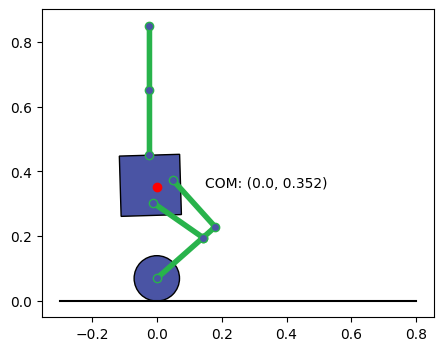

In [23]:
xi = np.array([ 0, -0.        ,  0.54856415,  3.73360672,  2.20638398,
                1.32402397, 0.00000000e+00, 0.00000000e+00,
                0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
ccc(x0)


In [24]:
# close()
%matplotlib qt
## example 1 for stablity
xi = np.array([ 0, -0.        ,  0.54856415,  3.73360672,  2.20638398,
                1.32402397, 0.00000000e+00, 0.00000000e+00,
                0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
## example 2 for stablity 
xi = np.array([ 0, -0.        ,  0.17,  3.73360672,  2.20638398,
                1.32402397, 0.00000000e+00, 0.00000000e+00,
                0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
ccc(xi)


[0.11836787 0.         0.30254058]


In [28]:
def ref(t):
    xf = np.array([-1.11197892e-15,  0.00000000e+00,  8.72664626e-01,  3.96335810e+00,
                    1.44418378e+00,  2.18311813e-01,  0.00000000e+00,  0.00000000e+00,
                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
    return x0
close('all')
Q = np.diag([100,100,100,100,10,10,
             1,1,1,1,1,1])
R = np.diag([50,50,50,100,100])
t_ = np.linspace(0,12,1000)
t_ = np.linspace(0,3,300)
cont = Controller(xi,ref,t_,Q=Q,R=R)
sol,refval,U=cont.runLQR()
plotlqr(sol,refval,U)

In [36]:
xi = np.array([ 0, -0.        ,  1.11856415,  3.83360672,  2.20638398,
                1.32402397, 0.00000000e+00, 0.00000000e+00,
                0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

def ref(t):
    xf = np.array([-1.11197892e-15,  0.00000000e+00,  8.72664626e-01,  3.96335810e+00,
                    1.44418378e+00,  2.18311813e-01,  0.00000000e+00,  0.00000000e+00,
                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
    
    return xf
Q = np.diag([100,100,100,100,10,10,
             1,1,1,1,1,1])
R = np.diag([50,50,50,100,100])
t_ = np.linspace(0,12,1000)
t_ = np.linspace(0,4,300)
cont = Controller(xi,ref,t_,Q=Q,R=R)
sol,refval,U=cont.runLQR()

rcParams['figure.figsize']= (18,12)
lab = ['$x$', '$\phi$', '$q_1$', '$q_4$', '$q_{a_{1}}$', '$q_{a_{2}}$', "$x'$", "$\phi'$", "$q_1'$", 
       "$q_4'$", "$q_{a_{1}}'$", "$q_{a_{2}}'$"]
laby = ['$x(m)$', '$\phi(rad)$', '$q_1(rad)$', '$q_4(rad)$', '$q_{a_{1}}(rad)$', '$q_{a_{2}}(rad)$', 
        "$x'$(m/s)", "$\phi'$(rad/s)", "$q_1'$(rad/s)", "$q_4'$(rad/s)", "$q_{a_{1}}'$(rad/s)", "$q_{a_{2}}'$(rad/s)"]
labr = ['$x_{\mathrm{ref}}$', '$\phi_{\mathrm{ref}}$', '$q_{1\mathrm{ref}}$', '$q_{4\mathrm{ref}}$', 
        '$q_{a_{1}\mathrm{ref}}$', '$q_{a_{2}\mathrm{ref}}$']
close()
lw =2
for i in range(12):
    subplot(4,3,i+1)
    plot(t_,sol[:,i],'r',linewidth = lw)
    if i<6:
        plot(t_,refval[:,i],'g',linewidth = lw)
        legend([lab[i],labr[i]],fontsize =12)
    else: 
        legend([lab[i]],fontsize =12)
    xlabel('t (sec)',fontsize = 12)
    ylabel(laby[i],fontsize = 12)
    tick_params(axis='both', labelsize=12)
subplots_adjust(hspace = 0.5,wspace= 0.25)
show()


In [37]:
lab = ['$T_l$', '$T_r$', '$T_m$', '$T_{a_{1}}$', '$T_{a_{2}}$']
close()
for i in range(5):
    subplot(3,2,i+1)
    plot(t_,U[:,i],'b',linewidth=lw)
    ylabel(lab[i]+' (N.m)',fontsize =12)
    xlabel('t (sec)',fontsize = 12)
    tick_params(axis='both', labelsize=12)
subplots_adjust(hspace = 0.35,wspace= None)
show()

In [38]:
# figsize(12,18)
# for i in [0, 5, 10, 15, 30, 50, 200, 299]:
#     ccc(sol[i])
#     savefig("C:\\Users\\pkver\\Desktop\\Thesis\\Tracking\\fig_{}.png".format(i))
#     close()

## Animation

In [39]:
import matplotlib.animation as animation
%matplotlib qt
fig, ax = subplots()
def update(frame, ax,fig):
    ax.clear()
    fig, ax = Animeccc(sol[frame], fig, ax)
    # ax.plot(xeff[:frame,0],xeff[:frame,2],'r')
    ax.set_title('time (sec) {}'.format(round(t_[frame],2)))

ani = animation.FuncAnimation(fig, update, frames=sol.shape[0], fargs=(ax,fig), interval=1)
plt.show()

## Stearing Analysis

### reference trajectory


In [40]:
## example 1 sinusoidal
def ref(t):
    phir = np.sin(t)*np.pi
    xf =x0.copy()
    xf[1] = phir
    return xf

## example 2 Circular
def ref(t,T=12):
    r=3
    phir = 2*np.pi*t/T
    xr = 2*np.pi*r*t/T
    xf =x0.copy()
    xf[0] = xr
    xf[1] = phir
    return xf


### STATE

In [43]:
xi = np.array([-4.33869546e-15,  0.00000000e+00,  8.72664626e-01,  3.96378377e+00,
                1.49742777e+00,  5.13132172e-02,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])


Q = np.diag([100,100,100,100,10,10,
             1,1,1,1,1,1])
R = np.diag([50,50,50,100,100])
t_ = np.linspace(0,15,1000)
# Q=Q,R=R
cont = Controller(x0,ref,t_,
                  Q=Q,R=R,
                  )
sol,refval,U=cont.runLQR()

rcParams['figure.figsize']= (18,12)
lab = ['$x$', '$\phi$', '$q_1$', '$q_4$', '$q_{a_{1}}$', '$q_{a_{2}}$', "$x'$", "$\phi'$", "$q_1'$", 
       "$q_4'$", "$q_{a_{1}}'$", "$q_{a_{2}}'$"]
laby = ['$x(m)$', '$\phi(rad)$', '$q_1(rad)$', '$q_4(rad)$', '$q_{a_{1}}(rad)$', '$q_{a_{2}}(rad)$', 
        "$x'$(m/s)", "$\phi'$(rad/s)", "$q_1'$(rad/s)", "$q_4'$(rad/s)", "$q_{a_{1}}'$(rad/s)", "$q_{a_{2}}'$(rad/s)"]
labr = ['$x_{\mathrm{ref}}$', '$\phi_{\mathrm{ref}}$', '$q_{1\mathrm{ref}}$', '$q_{4\mathrm{ref}}$', 
        '$q_{a_{1}\mathrm{ref}}$', '$q_{a_{2}\mathrm{ref}}$']
close()
figure()
lw =2
for i in range(12):
    subplot(4,3,i+1)
    plot(t_,sol[:,i],'r',linewidth = lw)
    if i<6:
        plot(t_,refval[:,i],'g',linewidth = lw)
        legend([lab[i],labr[i]],fontsize =10)
    else: 
        legend([lab[i]],fontsize =12)
    xlabel('t (sec)',fontsize = 12)
    ylabel(laby[i],fontsize = 12)
    tick_params(axis='both', labelsize=12)
subplots_adjust(hspace = 0.5,wspace= 0.25)
show()

### ERROR

In [44]:
# rcParams['figure.figsize']= (18,12)
lab = ['$x$', '$\phi$', '$q_1$', '$q_4$', '$q_{a_{1}}$', '$q_{a_{2}}$', "$x'$", "$\phi'$", "$q_1'$", 
       "$q_4'$", "$q_{a_{1}}'$", "$q_{a_{2}}'$"]
laby = ['$x(m)$', '$\phi(rad)$', '$q_1(rad)$', '$q_4(rad)$', '$q_{a_{1}}(rad)$', '$q_{a_{2}}(rad)$', 
        "$x'$(m/s)", "$\phi'$(rad/s)", "$q_1'$(rad/s)", "$q_4'$(rad/s)", "$q_{a_{1}}'$(rad/s)", "$q_{a_{2}}'$(rad/s)"]
labr = ['$x_{\mathrm{ref}}$', '$\phi_{\mathrm{ref}}$', '$q_{1\mathrm{ref}}$', '$q_{4\mathrm{ref}}$', 
        '$q_{a_{1}\mathrm{ref}}$', '$q_{a_{2}\mathrm{ref}}$']
close()
figure()
lw =2

for i in range(6):
    plot(t_, sol[:, i] - refval[:, i], linewidth=lw, label=lab[i] + ' error')
    legend(fontsize=10)
    xlabel('t (sec)', fontsize=12)
    ylabel('Error', fontsize=12)
    tick_params(axis='both', labelsize=12)
title('Error vs Time')
subplots_adjust(hspace = 0.5,wspace= 0.25)
show()
# savefig("C:\\Users\\pkver\\Desktop\\Thesis\\Tracking\\steering Analysis error exp2.png")
# close()

In [45]:
import matplotlib.pyplot as plt

for i in range(6):

    plt.plot(t_, sol[:, i] - refval[:, i], linewidth=lw, label=lab[i] + ' error')
    plt.legend(fontsize=10)
    plt.xlabel('t (sec)', fontsize=12)
    plt.ylabel('Error', fontsize=12)
    plt.tick_params(axis='both', labelsize=12)

plt.show()


### TORQUE

In [46]:
lab = ['$T_l$', '$T_r$', '$T_m$', '$T_{a_{1}}$', '$T_{a_{2}}$']
close()
for i in range(5):
    subplot(5,1,i+1)
    plot(t_,U[:,i],'b',linewidth=lw)
    ylabel(lab[i]+' (N.m)',fontsize =12)
    tick_params(axis='both', labelsize=12)
subplots_adjust(hspace = 0.5,wspace= None)
xlabel('t (sec)',fontsize = 12)
suptitle('Torque vs Time',fontsize = 16)
show()

In [47]:
import matplotlib.pyplot as plt

lab = ['$T_l$', '$T_r$', '$T_m$', '$T_{a_{1}}$', '$T_{a_{2}}$']

plt.close()

fig, axs = plt.subplots(5, 1, sharex=True)

for i in range(5):
    axs[i].plot(t_, U[:, i], 'b', linewidth=lw)
    axs[i].set_ylabel(lab[i] + ' (N.m)', fontsize=12)
    axs[i].tick_params(axis='both', labelsize=12)

plt.xlabel('t (sec)', fontsize=12)
fig.suptitle('Torque vs Time', fontsize=16, y=0.95)

plt.subplots_adjust(hspace=0.5, wspace=None)

plt.show()


### CARTESIAN TREJECTORY

In [48]:
X=[]; Y=[]
v = np.append([0],np.diff(sol[:,0]))
phi = sol[:,1]
xc=0; yc=0
for i in range(len(t_)):
    xc = xc + v[i] * np.cos(phi[i])
    yc = yc + v[i] * np.sin(phi[i]) 
    X.append(xc); Y.append(yc)
plot(X,Y)

In [49]:
X=np.array(X)
Y=np.array(Y)

In [50]:
close(0)
tc = np.linspace(0,10,1000)
plot(X,Y,'r')
plot(3*np.cos(2*np.pi*tc),3*np.sin(2*np.pi*tc)+3,'g')
axis('equal')
ylabel('y(m)',fontsize = 12)
xlabel('x(m)',fontsize =12)
legend(['Actual','Reference'],fontsize =12)
xlim([-5,4])
tick_params(axis='both', labelsize=12)
plot([0],[0],'bo',markersize =15,)
show()

In [51]:
plot(t_,U[:,0],'r')
plot(t_,U[:,1],'g')
# ylim([-0.1,0.1])